<a href="https://colab.research.google.com/github/RacerBeats/Midterm_project-datascience/blob/main/midterm_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Name: Ryan Cheung
MIDTERM PROJECT

Link: https://zenodo.org/records/4069457

About: This is data scraped from UFC.org's official fight database.

Motivation: I used to analyze data from fights by watching fights happen in footage. I want to analyze the data behind the fights, and see what exactly leads to a fighter's win or loss. Unlike the original study which made a more generalized analysis of the fight stats depending on KO or Decision, I want to analyze the results of a fight more closely, addressing each way to win in MMA (Submission, KO, Doctor's Stoppage, and Decisions).

questions:


1.   What is the most common method of victory in an MMA fight?
2.   Is there a difference beween performance metrics between men and women?
3.   how does attack rate correlate with victory method?
4.   which performance metric is the strongest predictor of victory?

5.   Are there significant differences in fight stats between weight class?
6.   do fighters with higher significant strike percentages win more frequently?
7.   do fighters in the red win more than fighters in the blue corner?







**Setup Phase:** Load CSV into Table

In [14]:
fight_results = Table.read_table("Lane_and_Briffa_MMA_Data_for_Dryad.csv")
fight_results.show(10)

Fight ID,Date,Red fighter,Blue fighter,Focal ID,Winner,Focal colour,Focal Outcome,Sex,Foc_Sig Str %,Z_Foc Sig Str %,Foc_Att strikes per sec,Z_Foc_Att strikes per sec,Method,Method_B
1,14/03/2020,Johnny Walker,Nikita Krylov,Johnny Walker,Blue,Red,Loser,M,74,1.95766,0.12,-0.618923,Decision,Decision
2,14/03/2020,Francisco Trinaldo,John Makdessi,John Makdessi,Red,Blue,Loser,M,54,0.622753,0.14,-0.483255,Decision,Decision
3,14/03/2020,Jussier Formiga,Brandon Moreno,Jussier Formiga,Blue,Red,Loser,M,46,0.0887907,0.09,-0.822425,Decision,Decision
4,14/03/2020,Amanda Ribas,Randa Markos,Randa Markos,Red,Blue,Loser,F,46,0.0887907,0.11,-0.686757,Decision,Decision
5,14/03/2020,Elizeu Zaleski dos Santos,Aleksi Kunchenko,Elizeu Zaleski dos Santos,Red,Red,Winner,M,39,-0.378426,0.19,-0.144085,Decision,Decision
6,14/03/2020,Marya Bueno Silva,Maryna Moroz,Maryna Moroz,Blue,Blue,Winner,F,56,0.756244,0.33,0.805591,Decision,Decision
7,14/03/2020,Bruno Silva,David Dvorak,Bruno Silva,Blue,Red,Loser,M,46,0.0887907,0.12,-0.618923,Decision,Decision
8,14/03/2020,Veronica Macedo,Bea Malecki,Bea Malecki,Blue,Blue,Winner,F,52,0.489262,0.36,1.00909,Decision,Decision
9,07/03/2020,Israel Adesanya,Yoel Romero,Israel Adesanya,Red,Red,Winner,M,36,-0.578662,0.09,-0.822425,Decision,Decision
10,07/03/2020,Weili Zhang,Joanna Jedrzejczyk,Joanna Jedrzejczyk,Red,Blue,Loser,F,51,0.422517,0.25,0.262919,Decision,Decision


Clean up data:

In [15]:
cleaned_fight_results = fight_results.drop('Fight ID', 'Method_B')
cleaned_fight_results.show(10)

Date,Red fighter,Blue fighter,Focal ID,Winner,Focal colour,Focal Outcome,Sex,Foc_Sig Str %,Z_Foc Sig Str %,Foc_Att strikes per sec,Z_Foc_Att strikes per sec,Method
14/03/2020,Johnny Walker,Nikita Krylov,Johnny Walker,Blue,Red,Loser,M,74,1.95766,0.12,-0.618923,Decision
14/03/2020,Francisco Trinaldo,John Makdessi,John Makdessi,Red,Blue,Loser,M,54,0.622753,0.14,-0.483255,Decision
14/03/2020,Jussier Formiga,Brandon Moreno,Jussier Formiga,Blue,Red,Loser,M,46,0.0887907,0.09,-0.822425,Decision
14/03/2020,Amanda Ribas,Randa Markos,Randa Markos,Red,Blue,Loser,F,46,0.0887907,0.11,-0.686757,Decision
14/03/2020,Elizeu Zaleski dos Santos,Aleksi Kunchenko,Elizeu Zaleski dos Santos,Red,Red,Winner,M,39,-0.378426,0.19,-0.144085,Decision
14/03/2020,Marya Bueno Silva,Maryna Moroz,Maryna Moroz,Blue,Blue,Winner,F,56,0.756244,0.33,0.805591,Decision
14/03/2020,Bruno Silva,David Dvorak,Bruno Silva,Blue,Red,Loser,M,46,0.0887907,0.12,-0.618923,Decision
14/03/2020,Veronica Macedo,Bea Malecki,Bea Malecki,Blue,Blue,Winner,F,52,0.489262,0.36,1.00909,Decision
07/03/2020,Israel Adesanya,Yoel Romero,Israel Adesanya,Red,Red,Winner,M,36,-0.578662,0.09,-0.822425,Decision
07/03/2020,Weili Zhang,Joanna Jedrzejczyk,Joanna Jedrzejczyk,Red,Blue,Loser,F,51,0.422517,0.25,0.262919,Decision


The data in this table is already pretty organized and concise. I removed the fight IDs since I don't need those. Just know that these fights took place from 2019 to 2020, so these datapoints are a little old. Additionally, the difference between Method and Method_B are the classification. In the original study, they wanted to know if these fight stats contributed to decision wins versus genuine defeats via KO or Submission. I want to get rid of this to answer my different questions from the original study.

**RESEARCH PHASE:** MANIPULATE TABLE AND MAKE SOME GRAPHS

question 1: What's the most common victory method in these matches?

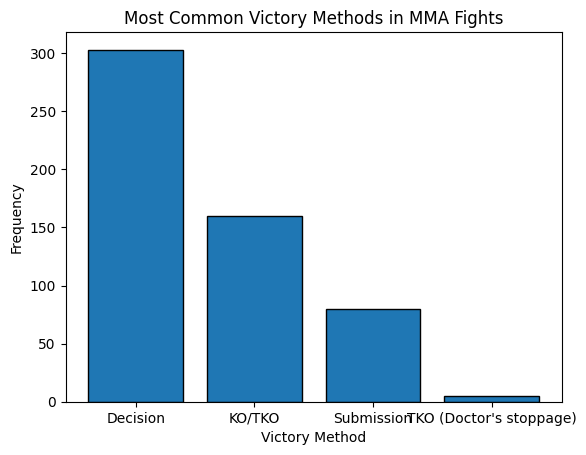

In [16]:
#Isolate Method tab first, count biggest amount of wins
method_counts = cleaned_fight_results.select('Method').group('Method')
sorted_method = method_counts.sort('count', descending=True)

#Create visuals
plt.bar(sorted_method.column('Method'), sorted_method.column('count'))
plt.xlabel("Victory Method")
plt.ylabel("Frequency")
plt.title("Most Common Victory Methods in MMA Fights")
plt.show()

I used a boxplot instead of a histogram since these datapoints are categorical instead of continuous integers. This graph clearly shows that Decisions are the main way that MMA fighters win.

question 2: Is there a difference beween performance metrics between men and women?




In [17]:
#Gather raw percents
male_sig_strike_percent = cleaned_fight_results.where('Sex', 'M').column('Foc_Sig Str %')
female_sig_strike_percent = cleaned_fight_results.where('Sex', 'F').column('Foc_Sig Str %')

#Gather raw attk / sec
male_strike_per_sec = cleaned_fight_results.where('Sex', 'M').column('Foc_Att strikes per sec')
female_strike_per_sec = cleaned_fight_results.where('Sex', 'F').column('Foc_Att strikes per sec')

#turn percents into a single average
avg_male_sig_strike_percent = np.mean(male_sig_strike_percent)
avg_female_sig_strike_percent = np.mean(female_sig_strike_percent)

print(f"The average male significant strike percentage: {avg_male_sig_strike_percent}")
print(f"The average female significant strike percentage: {avg_female_sig_strike_percent}")

#Calculate and show average strike / sec per sex
avg_make_strike_per_sec = np.mean(male_strike_per_sec)
avg_female_strike_per_sec = np.mean(female_strike_per_sec)

print(f"The average male strike per second: {avg_make_strike_per_sec}")
print(f"The average female strike per second: {avg_female_strike_per_sec}")

The average male significant strike percentage: 44.67040358744394
The average female significant strike percentage: 44.666666666666664
The average male strike per second: 0.20085201793721977
The average female strike per second: 0.25666666666666665


Findings: There is very little difference between men and women in terms of average significant strike percentage. There is a slight difference of abour 0.05 when comparing average strikes per second between men and women. This discrepancy suggests that female MMA fighters have to be slightly more active to maintain a similar performance / efficacy of output compared to male MMA fighters.

question 3: how does attack rate correlate with victory method?

Method                  | Foc_Att strikes per sec mean
Decision                | 0.168383
KO/TKO                  | 0.281125
Submission              | 0.226375
TKO (Doctor's stoppage) | 0.33


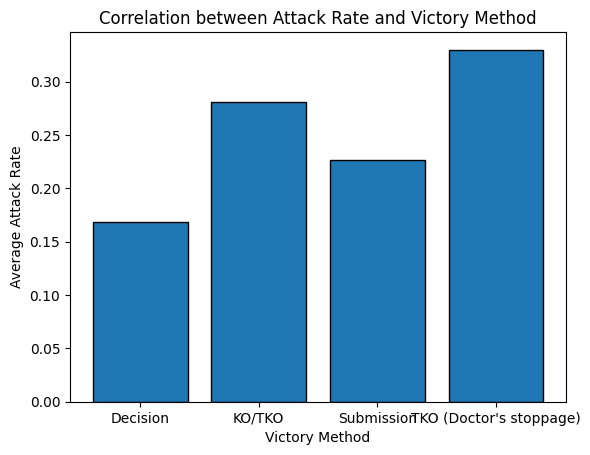

In [18]:
#find average strikes per sec mean per each method of win
attk_rate_by_method = cleaned_fight_results.select('Method', 'Foc_Att strikes per sec').group('Method', np.mean)
print(attk_rate_by_method)

plt.bar(attk_rate_by_method.column('Method'), attk_rate_by_method.column('Foc_Att strikes per sec mean'))
plt.xlabel("Victory Method")
plt.ylabel("Average Attack Rate")
plt.title("Correlation between Attack Rate and Victory Method")
plt.show()

Once again, I used a box graph to split this categorically, so a histogram is not the best choice here. As we can see, it's clear that lower attack rates correleate with decision wins. KO / TKOs are shown to happen when the attack rate is higher which makes sense in martial arts in general; the more attacks you send out, the higher chance one of them will land. Aggressive fighters will use higher attack rates to overwhelm an opponent into making a critical mistake, opening them up for a knockout blow. As for doctor stoppages, since the actual count for them is so rare, I believe that a figher must have attacked so much that the fight essentially ends early, which is still ruled as a TKO in these kinds of sports.

question 4: Who are the best and worst fighters in this slice of data in terms of wins and losses?

In [19]:
# Group by fighter name and count wins and losses
fighter_records = cleaned_fight_results.select('Focal ID', 'Focal Outcome').group('Focal ID')

# Create empty lists for Wins and Losses
wins_list = []
losses_list = []

# Iterate through each row and update wins and losses
for i in range(fighter_records.num_rows):
    fighter_id = fighter_records.column('Focal ID').item(i)
    outcomes = cleaned_fight_results.where('Focal ID', fighter_id).column('Focal Outcome')
    wins = np.count_nonzero(outcomes == 'Winner')
    losses = np.count_nonzero(outcomes == 'Loser')
    wins_list.append(wins)
    losses_list.append(losses)

# Add Wins and Losses columns to the table
fighter_records = fighter_records.with_columns(
    'Wins', wins_list,
    'Losses', losses_list
)

# Calculate win percentage
fighter_records = fighter_records.with_column('Win Percentage', fighter_records.column('Wins') / (fighter_records.column('Wins') + fighter_records.column('Losses')))

# Rename 'Focal ID' to 'Fighter' for clarity
fighter_records = fighter_records.relabeled('Focal ID', 'Fighter')

# Sort by win percentage to find the best and worst fighters
best_fighters = fighter_records.sort('Win Percentage', descending=True)
worst_fighters = fighter_records.sort('Win Percentage')

# Display the results
print("Best Fighters:")
best_fighters.show(5)  # Show top 5 best fighters
print("\nWorst Fighters:")
worst_fighters.show(5)  # Show top 5 worst fighters

Best Fighters:


Fighter,count,Wins,Losses,Win Percentage
Alex Caceres,1,1,0,1
Alex Perez,2,2,0,1
Alex White,1,1,0,1
Alexander Hernandez,1,1,0,1
Alexander Volkanovski,2,2,0,1



Worst Fighters:


Fighter,count,Wins,Losses,Win Percentage
Aalon Cruz,1,0,1,0
Abubakar Nurmagomedov,1,0,1,0
Al Iaquinta,1,0,1,0
Alejandro Perez,2,0,2,0
Aleksandar Rakic,1,0,1,0


its clear that some fighters dont compete often. this question is limited by the scope of the dataset, since most UFC fighters compete less frequently for protection of the overall career.


question 5: Is there an identifiable trend of changes in significant strikes and attack rates over the duration of this dataset?

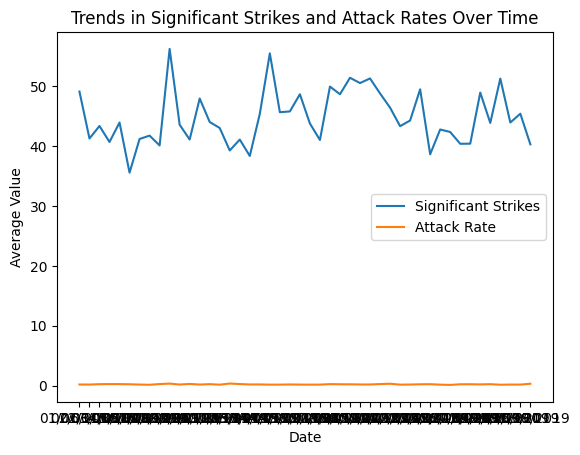

In [20]:
#group together date and sig strikes and attk rate
date_trends = cleaned_fight_results.select('Date', 'Foc_Sig Str %', 'Foc_Att strikes per sec').group('Date', np.mean)

plt.plot(date_trends.column('Date'), date_trends.column('Foc_Sig Str % mean'), label='Significant Strikes')
plt.plot(date_trends.column('Date'), date_trends.column('Foc_Att strikes per sec mean'), label='Attack Rate')
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.title('Trends in Significant Strikes and Attack Rates Over Time')
plt.legend()
plt.show()

The date is a little too cramped; but we can see here that the significant strikes change all the time during this study, never fitting closely to one average. Attack rates, however, are relatively constant.

question 6: do fighters with higher significant strike percentages win more frequently?

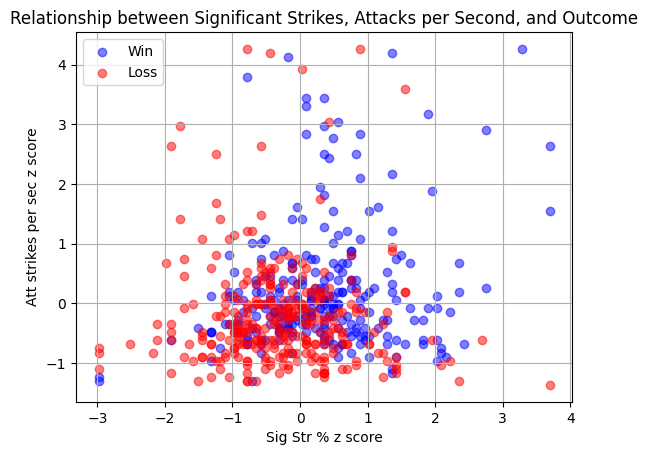

In [21]:
#extract columns
z_attk_per_sec = cleaned_fight_results.column('Z_Foc_Att strikes per sec')
z_sig_strike_percent = cleaned_fight_results.column('Z_Foc Sig Str %')
focal_outcome = cleaned_fight_results.column('Focal Outcome')

#create scatterplot
plt.scatter(z_sig_strike_percent[focal_outcome == 'Winner'],
            z_attk_per_sec[focal_outcome == "Winner"],
            color='blue', label='Win', alpha=0.5)
plt.scatter(z_sig_strike_percent[focal_outcome == 'Loser'],
            z_attk_per_sec[focal_outcome == 'Loser'],
            color='red', label='Loss', alpha=0.5)

plt.xlabel('Sig Str % z score')
plt.ylabel('Att strikes per sec z score')
plt.title('Relationship between Significant Strikes, Attacks per Second, and Outcome')
plt.legend()
plt.grid(True)
plt.show()

I chose a scatter plot for this one to identify clusters of the fighter's z scores in attacks per second and significan strikes landed. A z score is a measure of how many standard deviations a data point is away from the mean, which is a useful metric to measure how above or below average a fighter was in a win or a loss. There is a weak, but still present distinction that fighters with positive z scores in significant strikes landed and /or attacks thrown per second have a higher tendency to win, as shown in the blue dots. Some outlilers, like the one loss in the bottom right corner denote a high significant strike with a lower rate of attack. This means that in this particular fight, the fighter in question must have been attacking very conservatively, despite landing damaging strikes to an opponent. Unfortunately, the rate of attacks were too low, allowing the opponent to overwhelm the fighter in question.

However, with the previous graphs in mind, a win by decision is characterized by a lower rate of strikes thrown. This factor spreads out the blue scatterplot considerably, overlapping with the red.


question 7: do fighters in the red win more than fighters in the blue corner?

In [22]:
win_count = cleaned_fight_results.select('Winner').group('Winner')
sorted_win_count = win_count.sort('Winner')
red_wins = sorted_win_count.where('Winner', 'Red').column('count').item(0)
blue_wins = sorted_win_count.where('Winner', 'Blue').column('count').item(0)

print(f"Red wins: {red_wins}")
print(f"Blue wins: {blue_wins}")

Red wins: 319
Blue wins: 229


Surprisingly, there is an advantage when comparing the colors that the fighters use for identification. Fighters donning red taped / colored gloves have a tendency to win more often than the fighter with blue gloves.

## conclusion:

Generally speaking, the data behind a fight is extremely soradic due to all of the different factors that contribute to a fight. A particular fighter may be more of a wrestler, therefore throwing few strikes and opting for wrestling attempts, which this dataset did not account for.

Therefore, I identify that this data set is slightly biased towards striking martial artists. Even then, we can identify certain critical trends that are crucial indicators of the difference makers in a fight. Generally speaking, fights that end in a KO or Doctor's stoppage are due to the winning figher in question outputting more attacks per second, and / or landing more significant strikes over the course of the match, as demonstrated in question 6 and 3.

I was surprised to see that a difference in colored gloves that the fighter wears has some bearing on their chances of victory. Additionally, I did not expect to see that female fighters have more output of strikes than male fighters, but this may acutally make sense in hindsight; to compensate for a lack of power compared to a male fighter, a female fighter may opt to overwhelm an opponent with faster attacks to compensate for a lack of power.

Applying my new skills to this dataset was very interesting because I was finally able to analyze data from a topic that I was more passionate about, since martial arts is very personal to me. While my particular dataset has some holes, I was able to manage to fulfil the assignment's requirements pretty well.
